In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sklearn
import seaborn as sns
# Natural Language Processing (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Text Vectorization and Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

C:\Users\Dennis\anaconda3\envs\learn-env\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
with open('../Final_Intents.json', 'r') as file:
    data = json.load(file)

In [4]:
# formatting json to ensure keys read responses only
for entry in data:
    if "answers" in entry:
        entry["responses"] = entry.pop("answers")

intents_dict={}

QnA = []
tags = []

for intent in data:
    for question in intent["questions"]:
        tags.append(intent["tag"])
        QnA.append(question)
    for res in intent["responses"]:
        tags.append(intent["tag"])
        QnA.append(res)

intents_dict["QnA"] = QnA
intents_dict["tags"] = tags


In [5]:
df =  pd.DataFrame(intents_dict, columns=["QnA", "tags"])

# set seed to ensure reproducibility when shuffling
np.random.seed(42)
# shuffle to reduce bias and imrpove generalization
df = df.sample(frac=1).reset_index(drop=True)

df

,QnA,tags
0,Is the data science course full-time or part-t...,Data Science
1,Coding assignments in the part-time course ran...,Software Engineering
2,Does Moringa School provide support for career...,Data Science
3,Are there any hands-on learning opportunities ...,Data Science
4,"The course comprises five phases, with Phases ...",UI/UX
...,...,...
1035,Will I learn about the latest data science too...,Data Science
1036,Statistical knowledge is crucial for understan...,Data Science
1037,Release Managers play a crucial role in overse...,DevOps
1038,What tools and software are used for statistic...,Data Science


In [6]:
# Text Preprocessing
# Text Cleaning
df['QnA'] = df['QnA'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)
# Tokenization
df['QnA'] = df['QnA'].apply(word_tokenize)
# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['QnA'] =df['QnA'].apply(lambda x: [word for word in x if word not in stop_words])
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['QnA']= df['QnA'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Joining tokens
# Combine the list of tokens back into a string 
df['QnA'] = df['QnA'].apply(lambda x: ' '.join(x))

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['QnA'], df['tags'], test_size=0.2, random_state=42)

In [8]:
#  TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

Oversampling (RandomOverSampler) was employed to handle imbalanced class distribution in the training set. 

This is crucial for preventing the model from being biased towards the majority class.

In [10]:
# Data preprocessing and encoding
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the oversampled target variable
ohe = OneHotEncoder()
y_resampled_encoded = ohe.fit_transform(pd.DataFrame(y_resampled).values.reshape(-1, 1))

TF-IDF vectorization for text data and oversampling the training data to handle class imbalance.
One-hot encoding the oversampled target variable.

## Multinomial Naive Bayes Model

In [11]:
# Train a multinomial model
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

# Make predictions
predictions = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.7403846153846154
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       1.00      0.50      0.67         4
       Cybersecurity       0.62      0.62      0.62         8
        Data Science       0.94      0.75      0.84        89
              DevOps       0.55      0.75      0.63         8
          Enrollment       0.52      0.79      0.63        14
       Miscellaneous       0.70      0.58      0.63        33
  Mobile Development       0.33      0.56      0.42         9
Software Engineering       0.63      0.86      0.73        22
               UI/UX       0.81      0.93      0.87        14

            accuracy                           0.74       208
           macro avg       0.71      0.73      0.70       208
        weighted avg       0.78      0.74      0.75       208



In [12]:
# Evaluate the model on the test set
accuracy = nb_model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.74


Accuracy: 0.74 (test set), 0.93 (cross-validation)

Similar to Naive Bayes, the classification report provides precision, recall, and F1-score for each class. For example, the class "Data Science" has a precision of 0.85, recall of 0.92, and an F1-score of 0.89.

The model shows reasonable performance across multiple classes with a weighted average F1-score of 75%.

Some classes, like "Cloud Computing," achieved perfect precision and recall, indicating robust classification.

Other classes, such as "Software Engineering," also performed well, showing balanced precision and recall.

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.93636364 0.94545455 0.93939394 0.93333333 0.93636364]
Mean Accuracy: 0.9381818181818182


The cross-validation scores consistently indicate strong performance, with a mean accuracy of approximately 94%.

The model demonstrates stability and generalization across different folds.

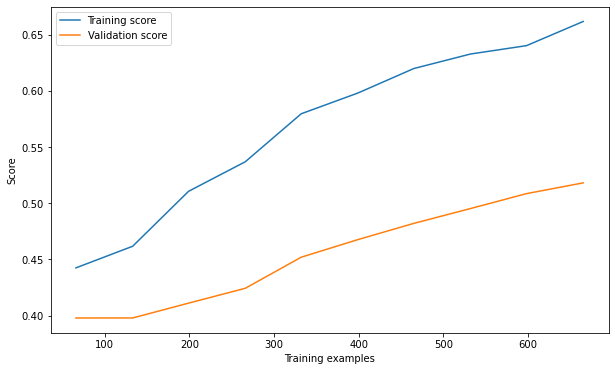

In [14]:
# Learning Curve
from sklearn.model_selection import learning_curve

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## Hyperparameter Tuning for Multinomial Naive Bayes

In [15]:
# Combine the oversampled training data and labels
resampled_data = pd.DataFrame(X_resampled.toarray(), columns=tfidf_vectorizer.get_feature_names())
resampled_data['tags'] = y_resampled

# Initialize the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Define the parameter grid
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Initialize GridSearchCV without validation_data
grid_search_nb = GridSearchCV(nb_model, param_grid=param_grid_nb, cv=5, scoring='accuracy')

# Perform grid search with cross-validation on the combined resampled data
grid_search_nb.fit(resampled_data.drop('tags', axis=1), resampled_data['tags'])

# Print the best parameters and the corresponding accuracy on the validation set
print("Best Parameters for Multinomial Naive Bayes:", grid_search_nb.best_params_)
print("Best Accuracy on Validation Set:", grid_search_nb.best_score_)

Best Parameters for Multinomial Naive Bayes: {'alpha': 0.1}
Best Accuracy on Validation Set: 0.95


In [16]:
# Evaluate the model on the test set
accuracy_test = grid_search_nb.score(X_test_tfidf, y_test)
print(f"Accuracy on the test set: {accuracy_test:.2f}")

Accuracy on the test set: 0.78


In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search_nb, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.95       0.95606061 0.95454545 0.9469697  0.9469697 ]
Mean Accuracy: 0.9509090909090909


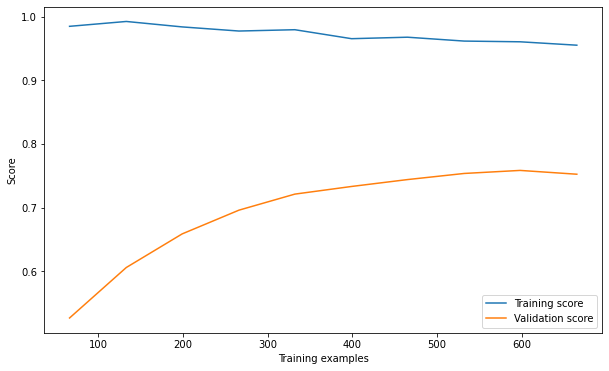

In [18]:
# Use the best estimator from the grid search
best_nb_model = grid_search_nb.best_estimator_

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_nb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

Accuracy: 0.74 (test set), 0.93 (cross-validation)
    
Good for text classification: Handles TF-IDF vectors well.
    
Hyperparameter Tuning: Improved accuracy to 0.78.
    
The learning curve illustrates that increasing the training examples could lead to improved performance on both the training and validation sets.


## XGBoost Model

In [19]:
# Train a model 
model = XGBClassifier()
model.fit(X_resampled, y_resampled)

# Make predictions
predictions = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.8317307692307693
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       1.00      0.50      0.67         4
       Cybersecurity       1.00      1.00      1.00         8
        Data Science       0.85      0.92      0.89        89
              DevOps       0.71      0.62      0.67         8
          Enrollment       0.71      0.71      0.71        14
       Miscellaneous       0.75      0.73      0.74        33
  Mobile Development       0.73      0.89      0.80         9
Software Engineering       0.84      0.73      0.78        22
               UI/UX       0.92      0.79      0.85        14

            accuracy                           0.83       208
           macro avg       0.85      0.79      0.81       208
        weighted avg       0.83      0.83      0.83       208



In [20]:
# Evaluate the model on the test set
accuracy = model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.83


Accuracy: 0.83 (test set), 0.98 (cross-validation), indicating it's learning patterns from the data.

Ensemble method: Often outperforms single models for complex tasks.

Hyperparameter Tuning: Optimized accuracy to 0.83.
    
The Random Forest model performs well, achieving a balanced accuracy across various classes.

It excels in classes like "Cloud Computing," "Cybersecurity," and "Data Science."

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.98787879 0.99090909 0.98636364 0.97878788 0.99090909]
Mean Accuracy: 0.986969696969697


Cross-validation scores are consistently high, indicating robust performance across different folds.

Cross-validation scores consistently exceed 98%, showcasing the model's high accuracy and stability across different folds.

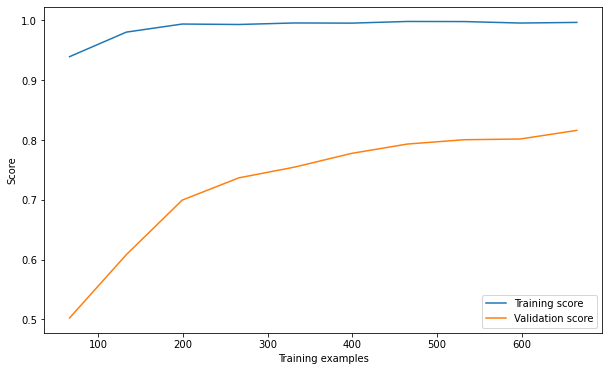

In [23]:
# Learning Curve
from sklearn.model_selection import learning_curve

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    XGBClassifier(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## Hyperparameter Tuning for XGBoost

In [24]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier()

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy')

# Perform grid search
grid_search_xgb.fit(X_resampled, y_resampled)

# Print the best parameters and the corresponding accuracy
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Accuracy for XGBoost:", grid_search_xgb.best_score_)

Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best Accuracy for XGBoost: 0.9878787878787879


In [25]:
xgb_model = XGBClassifier(**grid_search_xgb.best_params_)
xgb_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
accuracy = xgb_model.score(X_test_tfidf, y_test)
accuracy

0.8269230769230769

In [26]:
# Evaluate the model on the test set
accuracy = grid_search_xgb.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.83


In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search_xgb, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.98787879 0.98939394 0.99090909 0.97878788 0.99090909]
Mean Accuracy: 0.9875757575757577


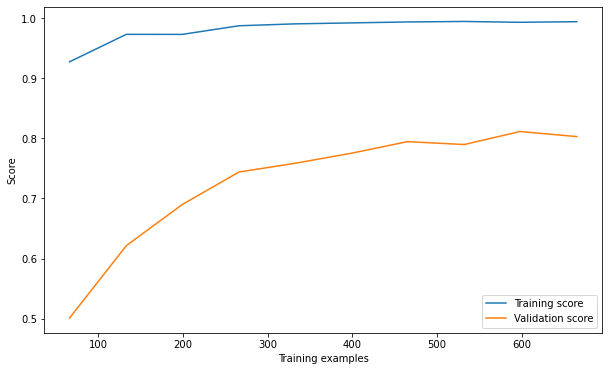

In [28]:
# Use the best estimator from the grid search
best_xgb_model = grid_search_xgb.best_estimator_

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

The learning curve indicates that increasing the training examples could lead to further improvements in both training and validation scores.

The model shows the potential for continued enhancement with more data.
    
Learning Curve: Shows better generalization than Naive Bayes.

## RandomForest Model

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_resampled, y_resampled)

# Make predictions
rf_predictions = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Random Forest Model Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

Random Forest Model Accuracy: 0.8701923076923077
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       0.67      0.50      0.57         4
       Cybersecurity       0.89      1.00      0.94         8
        Data Science       0.90      0.93      0.92        89
              DevOps       1.00      0.62      0.77         8
          Enrollment       0.77      0.71      0.74        14
       Miscellaneous       0.78      0.76      0.77        33
  Mobile Development       0.80      0.89      0.84         9
Software Engineering       0.88      0.95      0.91        22
               UI/UX       0.92      0.86      0.89        14

            accuracy                           0.87       208
           macro avg       0.86      0.82      0.84       208
        weighted avg       0.87      0.87      0.87       208



In [30]:
# Evaluate the model on the test set
accuracy = rf_model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.87


The Random Forest model performs well, achieving a balanced accuracy across various classes.

It excels in classes like "Cloud Computing," "Cybersecurity," and "Data Science."

Similar to the other models, the classification report provides precision, recall, and F1-score for each class. For example, the class "Data Science" has a precision of 0.90, recall of 0.93, and an F1-score of 0.92.

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.99242424 0.98787879 0.98939394 0.98333333 0.99242424]
Mean Accuracy: 0.989090909090909


Cross-validation scores are consistently high, indicating robust performance across different folds.

The mean accuracy is approximately 99%, showcasing the model's ability to generalize.

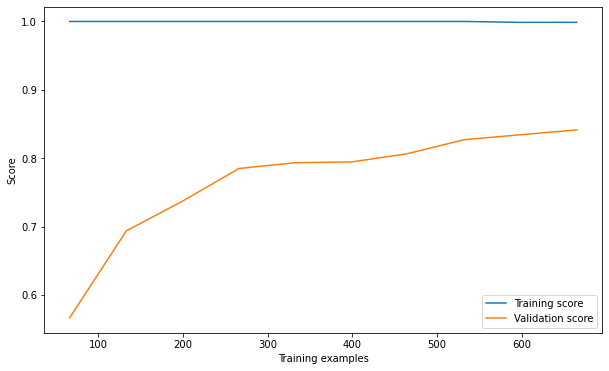

In [32]:
# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## Hyperparameter Tuning for RandomForest

In [33]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy')

# Perform grid search
grid_search_rf.fit(X_resampled, y_resampled)

# Print the best parameters and the corresponding accuracy
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Accuracy for Random Forest:", grid_search_rf.best_score_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy for Random Forest: 0.9903030303030302


In [34]:
# Evaluate the model on the test set
accuracy = grid_search_rf.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.88


In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search_rf, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.99090909 0.99242424 0.99242424 0.97878788 0.99242424]
Mean Accuracy: 0.9893939393939393


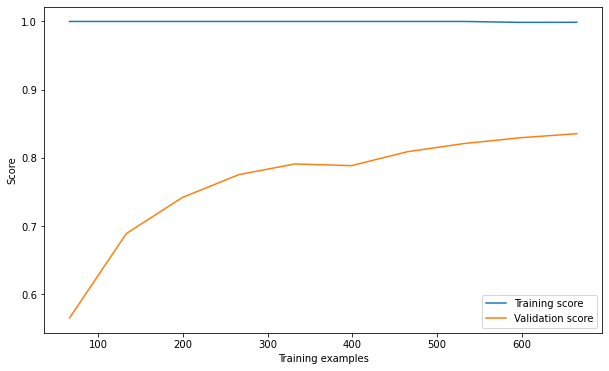

In [36]:
# Use the best estimator from the grid search
best_rf_model = grid_search_rf.best_estimator_

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

The learning curve suggests that the Random Forest model benefits from additional training examples, as both training and validation scores show potential for improvement.

#### Accuracy on Test Set:

Random Forest achieved the highest accuracy on the test set (87%), followed by XGBoost (83%) and Multinomial Naive Bayes (74%).

#### Considerations:

Random Forest and XGBoost outperform Multinomial Naive Bayes, suggesting that ensemble methods might capture complex relationships in the data better.


In [37]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "What support does Moringa School offer for graduates' career development?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = model.predict(vectorized_txt)

print(pred)

['Miscellaneous']


In [38]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "How is the curriculum at Moringa School tailored to market-aligned skills in Cloud Computing ?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = grid_search_xgb.predict(vectorized_txt)

print(pred)

['Cloud Computing']


In [39]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "What support does Moringa School offer for graduates' career development??"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = rf_model.predict(vectorized_txt)

print(pred)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "What support does Moringa School offer for graduates' career development?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = grid_search_rf.predict(vectorized_txt)

print(pred)